In [2]:
!pip install -q geopandas rasterio shapely fiona rtree pyproj scipy scikit-learn pandas matplotlib requests joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 42.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import mapping
from scipy import integrate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import json, os, joblib
def make_dummy_json(n=50):
    np.random.seed(42)
    features = []
    for i in range(n):
        ndvi_pre = np.random.uniform(0.6, 0.9)
        ndvi_post = ndvi_pre - np.random.uniform(0.0, 0.4)
        ndbi_pre = np.random.uniform(0.1, 0.4)
        ndbi_post = ndbi_pre + np.random.uniform(0.0, 0.3)
        area = np.random.uniform(300, 10000)
        depth = np.abs(np.random.normal(8, 6))
        volume = area * depth / 3.0
        features.append({
            "polygon_id": f"poly_{i+1}",
            "NDVI_pre": ndvi_pre,
            "NDVI_post": ndvi_post,
            "NDBI_pre": ndbi_pre,
            "NDBI_post": ndbi_post,
            "area_m2": area,
            "depth_m": depth,
            "volume_m3": volume,
            "is_legal": int((ndvi_pre - ndvi_post < 0.1) and (depth < 10))
        })
    return {"features": features}

raw = make_dummy_json(80)
df = pd.json_normalize(raw["features"])
df.head()


,polygon_id,NDVI_pre,NDVI_post,NDBI_pre,NDBI_post,area_m2,depth_m,volume_m3,is_legal
0,poly_1,0.712362,0.332076,0.319598,0.499196,1813.380812,9.674248,5847.698416,0
1,poly_2,0.812422,0.804188,0.390973,0.640706,2359.689374,14.063092,11061.509355,0
2,poly_3,0.654547,0.581186,0.191273,0.348700,4489.866681,12.898670,19304.436947,0
3,poly_4,0.641848,0.524990,0.209909,0.346730,7916.206826,1.143256,3016.750279,0
4,poly_5,0.659902,0.454208,0.277724,0.291659,6193.185063,4.398477,9080.193812,0


In [4]:
df["dNDVI"] = df["NDVI_pre"] - df["NDVI_post"]
df["dNDBI"] = df["NDBI_post"] - df["NDBI_pre"]
df["area_log"] = np.log1p(df["area_m2"])
df["depth_norm"] = df["depth_m"] / df["depth_m"].max()
df["volume_norm"] = df["volume_m3"] / df["volume_m3"].max()

X = df[["dNDVI","dNDBI","depth_norm","volume_norm","area_log"]]
y = df["is_legal"]

model = RandomForestClassifier(n_estimators=150, random_state=42, class_weight="balanced")
model.fit(X, y)
df["prob_illegal"] = model.predict_proba(X)[:,0]
df["confidence"] = (df["prob_illegal"] * 100).round(2)

df.head()


,polygon_id,NDVI_pre,NDVI_post,NDBI_pre,NDBI_post,area_m2,depth_m,volume_m3,is_legal,dNDVI,dNDBI,area_log,depth_norm,volume_norm,prob_illegal,confidence
0,poly_1,0.712362,0.332076,0.319598,0.499196,1813.380812,9.674248,5847.698416,0,0.380286,0.179598,7.503500,0.392148,0.117433,1.000000,100.00
1,poly_2,0.812422,0.804188,0.390973,0.640706,2359.689374,14.063092,11061.509355,0,0.008234,0.249733,7.766709,0.570051,0.222136,0.853333,85.33
2,poly_3,0.654547,0.581186,0.191273,0.348700,4489.866681,12.898670,19304.436947,0,0.073362,0.157427,8.409801,0.522851,0.387670,0.913333,91.33
3,poly_4,0.641848,0.524990,0.209909,0.346730,7916.206826,1.143256,3016.750279,0,0.116858,0.136821,8.976794,0.046342,0.060582,0.986667,98.67
4,poly_5,0.659902,0.454208,0.277724,0.291659,6193.185063,4.398477,9080.193812,0,0.205694,0.013935,8.731366,0.178293,0.182348,0.993333,99.33


In [5]:
# Example using dummy depth map (replace with real DEM later)

df["mean_depth_m"] = df["depth_m"]
df["max_depth_m"] = df["depth_m"] * np.random.uniform(1.1, 1.5, len(df))
df["volume_m3_simpson"] = df["volume_m3"] * np.random.uniform(0.95, 1.05, len(df))


In [6]:
def ndvi_to_biomass_tC_per_ha(ndvi):
    if ndvi >= 0.6: return 150
    elif ndvi >= 0.4: return 100
    elif ndvi >= 0.2: return 50
    else: return 10

records = []
for _, r in df.iterrows():
    area_ha = r["area_m2"] / 10000
    biomass_tC_ha = ndvi_to_biomass_tC_per_ha(r["NDVI_pre"])
    soil_c_tC_ha = 10  # constant assumption
    biomass_loss_tC = biomass_tC_ha * area_ha * 0.5
    soil_loss_tC = soil_c_tC_ha * area_ha * 0.2
    total_loss_tC = biomass_loss_tC + soil_loss_tC
    total_loss_CO2e = total_loss_tC * (44/12)

    records.append({
        "polygon_id": r["polygon_id"],
        "biomass_loss_tC": biomass_loss_tC,
        "soil_loss_tC": soil_loss_tC,
        "total_loss_tC": total_loss_tC,
        "total_loss_CO2e_tons": total_loss_CO2e
    })

carbon_df = pd.DataFrame(records)
df = df.merge(carbon_df, on="polygon_id")
df.head()


,polygon_id,NDVI_pre,NDVI_post,NDBI_pre,NDBI_post,area_m2,depth_m,volume_m3,is_legal,dNDVI,...,volume_norm,prob_illegal,confidence,mean_depth_m,max_depth_m,volume_m3_simpson,biomass_loss_tC,soil_loss_tC,total_loss_tC,total_loss_CO2e_tons
0,poly_1,0.712362,0.332076,0.319598,0.499196,1813.380812,9.674248,5847.698416,0,0.380286,...,0.117433,1.000000,100.00,9.674248,14.317112,5630.190840,13.600356,0.362676,13.963032,51.197785
1,poly_2,0.812422,0.804188,0.390973,0.640706,2359.689374,14.063092,11061.509355,0,0.008234,...,0.222136,0.853333,85.33,14.063092,19.551745,10676.461194,17.697670,0.471938,18.169608,66.621897
2,poly_3,0.654547,0.581186,0.191273,0.348700,4489.866681,12.898670,19304.436947,0,0.073362,...,0.387670,0.913333,91.33,12.898670,17.353434,18607.213140,33.674000,0.897973,34.571973,126.763903
3,poly_4,0.641848,0.524990,0.209909,0.346730,7916.206826,1.143256,3016.750279,0,0.116858,...,0.060582,0.986667,98.67,1.143256,1.448845,3059.248672,59.371551,1.583241,60.954793,223.500906
4,poly_5,0.659902,0.454208,0.277724,0.291659,6193.185063,4.398477,9080.193812,0,0.205694,...,0.182348,0.993333,99.33,4.398477,6.479358,8791.334763,46.448888,1.238637,47.687525,174.854258


In [7]:
payload = {
    "summary": {
        "total_polygons": int(len(df)),
        "avg_confidence": float(df["confidence"].mean()),
        "illegal_estimate_count": int((df["prob_illegal"]>0.5).sum()),
        "total_CO2e_tons": float(df["total_loss_CO2e_tons"].sum())
    },
    "polygons": df.to_dict(orient="records")
}

with open("combined_payload.json", "w") as f:
    json.dump(payload, f, indent=2)

print("✅ combined_payload.json saved successfully!")
print(json.dumps(payload["summary"], indent=2))


✅ combined_payload.json saved successfully!
{
  "total_polygons": 80,
  "avg_confidence": 92.066375,
  "illegal_estimate_count": 73,
  "total_CO2e_tons": 11216.78858501952
}


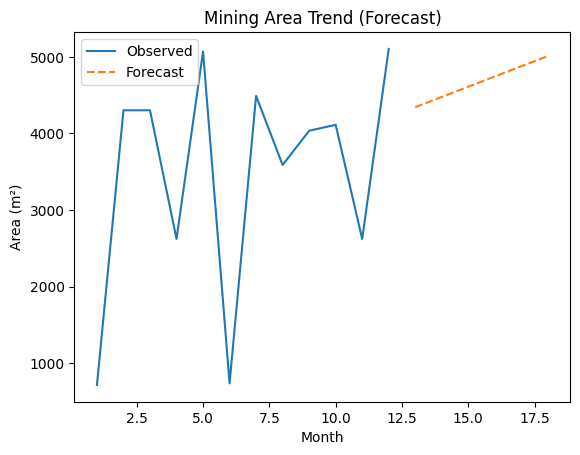

In [8]:
months = np.arange(1, 13)
area_series = df["area_m2"].sample(12, replace=True).values
lr = LinearRegression().fit(months.reshape(-1,1), area_series)
pred = lr.predict(np.arange(13, 19).reshape(-1,1))

plt.plot(months, area_series, label="Observed")
plt.plot(np.arange(13, 19), pred, "--", label="Forecast")
plt.title("Mining Area Trend (Forecast)")
plt.xlabel("Month"); plt.ylabel("Area (m²)")
plt.legend(); plt.show()


In [9]:
# Save the trained model for backend usage
joblib.dump(model, "random_forest_mining.pkl")
print("✅ Model saved as random_forest_mining.pkl")

# Define inference function (this will be exported separately too)
def predict_mining_activity(input_json, model_path="random_forest_mining.pkl"):
    """
    input_json must be in format:
    {
        "features": [
            {
                "NDVI_pre": ...,
                "NDVI_post": ...,
                "NDBI_pre": ...,
                "NDBI_post": ...,
                "depth_m": ...,
                "volume_m3": ...,
                "area_m2": ...
            }
        ]
    }
    """
    # Load model
    rf = joblib.load(model_path)

    # Convert JSON to DataFrame
    df_new = pd.json_normalize(input_json["features"])

    # Recreate features
    df_new["dNDVI"] = df_new["NDVI_pre"] - df_new["NDVI_post"]
    df_new["dNDBI"] = df_new["NDBI_post"] - df_new["NDBI_pre"]
    df_new["area_log"] = np.log1p(df_new["area_m2"])
    df_new["depth_norm"] = df_new["depth_m"] / df_new["depth_m"].max()
    df_new["volume_norm"] = df_new["volume_m3"] / df_new["volume_m3"].max()

    X_new = df_new[["dNDVI","dNDBI","depth_norm","volume_norm","area_log"]]

    # Predict
    preds = rf.predict(X_new)
    probs = rf.predict_proba(X_new)[:, 1]

    df_new["prediction"] = ["Illegal" if p==1 else "Legal" for p in preds]
    df_new["confidence"] = (probs * 100).round(2)

    return df_new.to_dict(orient="records")


✅ Model saved as random_forest_mining.pkl
